# Experiments for master's thesis


Settings

In [1]:
CONFIG = {'artifacts_dir': 'artifacts'}

Prep for experiments

In [2]:
from typing import Tuple, Callable
import torchvision
import numpy
import torch
from lrp import norm, image

# Normalization
norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ILSVRC2012_BatchNorm()

# Input data
img: numpy.array = image.load_normalized_img('../castle.jpg')
X: torch.Tensor = norm_fn(image.img_to_tensor(img))

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

## Hyperparameter Grid Search

In [3]:
from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

import experiments

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

### Gamma Rule

Create a grid search for the gamma rule.

In [4]:
hyperparams: numpy.ndarray = numpy.linspace(0.0, 1.0, num=20)
hyperparam_name = 'gamma'
output_dir_path: str = f'{CONFIG["artifacts_dir"]}/composite/gamma'

# Rule-Layer Mapping
name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': None}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

def name_map_hyperparam_setter(gamma: float) -> None:
    r'''Set the missing hyperparameter for the LRP rule.

    :param gamma: The value of the hyperparameter.
    '''
    name_map[1][2]['gamma'] = gamma

e = experiments.Experiments(model, X, name_map, output_dir_path)
results = e.generate_multiple_lrp_relevances(hyperparams, name_map_hyperparam_setter)

Using cached results


#### Grid plot

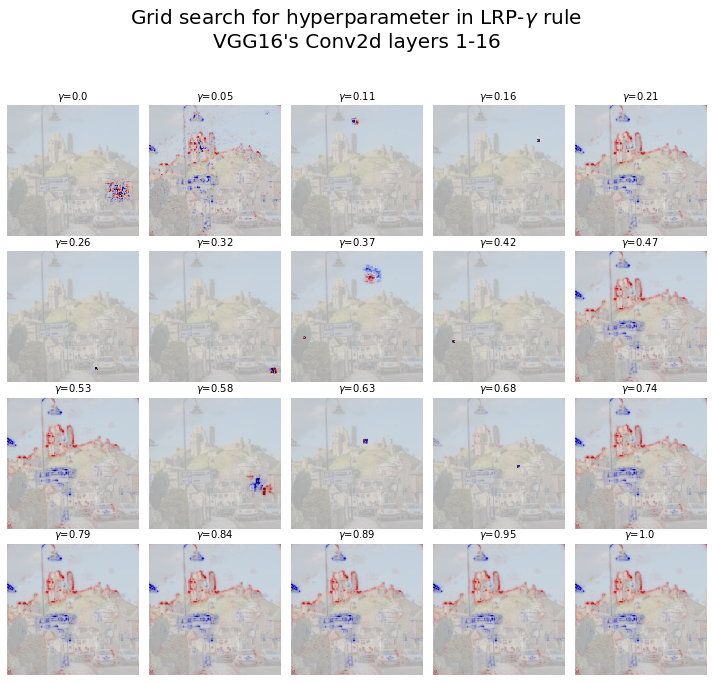

In [5]:
import lrp.plot

title = "Grid search for hyperparameter in LRP-$\gamma$ rule\nVGG16's Conv2d layers 1-16"
filename = 'high-res-gammas-lrp.png'

lrp.plot.grid(results,
              title=title,
              filename=f'{output_dir_path}/{filename}',
              image=img,
              gridsize=(4, 5),
              param_name='$\gamma$',
              param_print=lambda p: round(p, 2))

# ToDo:

## Today

- Create a function for generating parameters (gammas)
- Plot results with tensorboard

## Tomorrow

- Start writing thesis
- Prepare slides for meeting with Gregoire
  - Include a visual mapping of layers to rules
- Check reading list (slides on representation learning)

### Context 

Try to visualize network structure (perhaps using graphs). Saved links to reading list.

Found this repo which creates saliency maps for images:
- Find out which algorithm is used in [flashtorch](https://github.com/MisaOgura/flashtorch) to compute saliency maps.
  - Check ~/Downloads/flashtorch


---


## Nice-to-haves

- **Heuristic for `stabilize` function to scale epsilon according to dividend**
<!-- - Remove empty parameter for LrpZeroRule (set default value for `rule_kwargs` to `{}`) -->
- Implement debug function to print with toggle and remove print statements
- Use torchvision.transforms.Compose
- Integrate DataLoader into notebook
- Canonize models
